# <center> Задача восстановления регрессии</center>
## <center>Lasso- и Ridge-регрессия</center>

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from cycler import cycler
from matplotlib import pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import KFold, cross_val_score

**Будем работать с набором данных по ценам на дома в Бостоне (репозиторий UCI).**
**Загружаем данные.**

In [3]:
diabetes = load_diabetes()
X, y = diabetes["data"], diabetes["target"]

**Почитаем описание набора данных:**

In [4]:
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

**Признаки:**
- age  -  возраст в годах
- sex  -  пол человека
- bmi  -  индекс массы тела
- bp   -  среднее артериальное давление
- s1   -  TC, общий холестерин
- s2   -  LDL, низжняя плотность липопротеинов
- s3   -  HDL, высшая плотность липопротеинов
- s4   -  TCH, общий холестерин / HDL
- s5   -  LTG, логарифм уровня триглицеридов в сыворотке
- s6   -  GLU, уровень сахара в крови

In [5]:
diabetes.feature_names

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

**Посмотрим на первые 2 записи.**

In [6]:
X[:2]

array([[ 0.03807591,  0.05068012,  0.06169621,  0.02187235, -0.0442235 ,
        -0.03482076, -0.04340085, -0.00259226,  0.01990842, -0.01764613],
       [-0.00188202, -0.04464164, -0.05147406, -0.02632783, -0.00844872,
        -0.01916334,  0.07441156, -0.03949338, -0.06832974, -0.09220405]])

## Lasso-регрессия

Lasso-регрессия решает задачу минимизации среднеквардатичной ошибки с L1-регуляризацией:
$$\Large error(X, y, w) = \frac{1}{2} \sum_{i=1}^\ell {(y_i - w^Tx_i)}^2 + \alpha \sum_{i=1}^d |w_i|$$

где $y = w^Tx$ – уравнение гиперплоскости, зависящее от параметров модели $w$, $\ell$-число объектов в выборке $X$, $d$ – число признаков, $y$ – значения целевого признака, $\alpha$ – коэффициент регуляризации.

**Обучим Lasso-регрессию с небольшим коэффициентом $\alpha$ (слабая регуляризация). Обнуляется только коэффициент при признаке NOX (концентрация оксидов азота). Значит, он наименее важен для предсказания целевого признака – медианной стоимости домов в районе.**

In [7]:
lasso = Lasso(alpha=0.1)
lasso.fit(X, y)
lasso.coef_

array([  -0.        , -155.36288234,  517.18201661,  275.08235083,
        -52.54026923,   -0.        , -210.15975349,    0.        ,
        483.91440913,   33.67282148])

**Обучим Lasso-регрессию с коэффициентом $\alpha=10$. Теперь ненулевые коэффициенты остались только при признаках ZN (процент жилых участков площадью больше 25 тыс. кв. футов), TAX (уровень налогов), B (процент афроамериканцев) и LSTAT (процент граждан с низким уровнем жизни).**

In [8]:
lasso = Lasso(alpha=10)
lasso.fit(X, y)
lasso.coef_

array([ 0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.])

**Таким образом, Lasso-регрессия служит методом отбора признаков.**

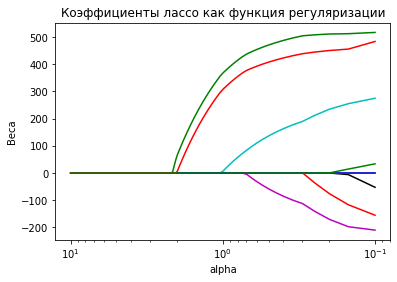

In [9]:
n_alphas = 200
alphas = np.linspace(0.1, 10, n_alphas)
model = Lasso()

coefs = []
for a in alphas:
    model.set_params(alpha=a)
    model.fit(X, y)
    coefs.append(model.coef_)

ax = plt.gca()
ax.set_prop_cycle(cycler("color", ["b", "r", "g", "c", "k", "y", "m"]))

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("Веса")
plt.title("Коэффициенты лассо как функция регуляризации")
plt.axis("tight")
plt.show();

**Теперь определим лучшее значение $\alpha$ в процессе кросс-валидации.**

In [10]:
lasso_cv = LassoCV(alphas=alphas, cv=3, random_state=17)
lasso_cv.fit(X, y)

LassoCV(alphas=array([ 0.1       ,  0.14974874,  0.19949749,  0.24924623,  0.29899497,
        0.34874372,  0.39849246,  0.44824121,  0.49798995,  0.54773869,
        0.59748744,  0.64723618,  0.69698492,  0.74673367,  0.79648241,
        0.84623116,  0.8959799 ,  0.94572864,  0.99547739,  1.04522613,
        1.09497487,  1.14472362,  1.19447236,  1.24422111,  1.29396985,
        1.34371859,  1.39346734,  1.44321608,  1.49296482,  1.54271357,
        1.5924...
        8.30854271,  8.35829146,  8.4080402 ,  8.45778894,  8.50753769,
        8.55728643,  8.60703518,  8.65678392,  8.70653266,  8.75628141,
        8.80603015,  8.85577889,  8.90552764,  8.95527638,  9.00502513,
        9.05477387,  9.10452261,  9.15427136,  9.2040201 ,  9.25376884,
        9.30351759,  9.35326633,  9.40301508,  9.45276382,  9.50251256,
        9.55226131,  9.60201005,  9.65175879,  9.70150754,  9.75125628,
        9.80100503,  9.85075377,  9.90050251,  9.95025126, 10.        ]),
        cv=3, random_state=17

In [12]:
lasso_cv.coef_

array([  -0.        , -155.36288234,  517.18201661,  275.08235083,
        -52.54026923,   -0.        , -210.15975349,    0.        ,
        483.91440913,   33.67282148])

In [13]:
lasso_cv.alpha_

0.1

**Метод `cross_val_score` максимизирует метрику, так что вместо 
минимизации MSE сделаем максимизацию отрицательного MSE – `neg_mean_squared_error`.**

In [14]:
cross_val_score(Lasso(lasso_cv.alpha_), X, y, cv=3, scoring="neg_mean_squared_error")

array([-3113.87280074, -3191.07748341, -2805.20835925])

**Чтобы все-таки трактовать результат в терминах MSE, выведем модуль среднего значения метрики `neg_mean_squared_error` на кросс-валидации.**

In [15]:
abs(
    np.mean(
        cross_val_score(
            Lasso(lasso_cv.alpha_), X, y, cv=3, scoring="neg_mean_squared_error"
        )
    )
)

3036.7195478003355

In [16]:
abs(np.mean(cross_val_score(Lasso(9.95), X, y, cv=3, scoring="neg_mean_squared_error")))

5943.716736095004

**Еще один неоднозначный момент: LassoCV сортирует значения параметров по убыванию – так проще оптимизировать. Из-за этого может показаться, что оптимизация параметра $\alpha$ работает неправильно**

In [17]:
lasso_cv.alphas[:10]  # значения параметров на входе

array([0.1       , 0.14974874, 0.19949749, 0.24924623, 0.29899497,
       0.34874372, 0.39849246, 0.44824121, 0.49798995, 0.54773869])

In [18]:
lasso_cv.alphas_[:10]  # преобразованные значения параметров

array([10.        ,  9.95025126,  9.90050251,  9.85075377,  9.80100503,
        9.75125628,  9.70150754,  9.65175879,  9.60201005,  9.55226131])

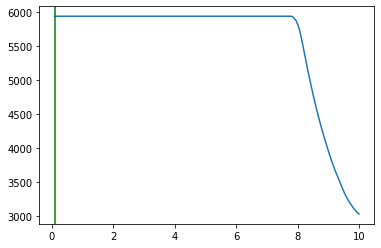

In [19]:
plt.plot(lasso_cv.alphas, lasso_cv.mse_path_.mean(1))  # неверно
plt.axvline(lasso_cv.alpha_, c="g");

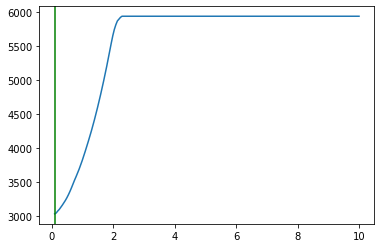

In [20]:
plt.plot(lasso_cv.alphas_, lasso_cv.mse_path_.mean(1))  # верно
plt.axvline(lasso_cv.alpha_, c="g");

## Ridge-регрессия

Ridge-регрессия (или гребневая регрессия) решает задачу минимизации среднеквардатичной ошибки с L2-регуляризацией:
$$\Large error(X, y, w) = \frac{1}{2} \sum_{i=1}^\ell {(y_i - w^Tx_i)}^2 + \alpha \sum_{i=1}^d w_i^2$$

где $y = w^Tx$ – уравнение гиперплоскости, зависящее от параметров модели $w$, $\ell$-число объектов в выборке $X$, $d$ – число признаков, $y$ – значения целевого признака, $\alpha$ – коэффициент регуляризации.

В sklearn реализован специальный класс [RidgeCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV) для кросс-валидации с Ridge-регрессией.

In [21]:
n_alphas = 200
ridge_alphas = np.logspace(-2, 6, n_alphas)

In [22]:
ridge_cv = RidgeCV(alphas=ridge_alphas, scoring="neg_mean_squared_error", cv=3)
ridge_cv.fit(X, y)

RidgeCV(alphas=array([1.00000000e-02, 1.09698580e-02, 1.20337784e-02, 1.32008840e-02,
       1.44811823e-02, 1.58856513e-02, 1.74263339e-02, 1.91164408e-02,
       2.09704640e-02, 2.30043012e-02, 2.52353917e-02, 2.76828663e-02,
       3.03677112e-02, 3.33129479e-02, 3.65438307e-02, 4.00880633e-02,
       4.39760361e-02, 4.82410870e-02, 5.29197874e-02, 5.80522552e-02,
       6.36824994e-02, 6.98587975e-0...
       1.18953407e+05, 1.30490198e+05, 1.43145894e+05, 1.57029012e+05,
       1.72258597e+05, 1.88965234e+05, 2.07292178e+05, 2.27396575e+05,
       2.49450814e+05, 2.73644000e+05, 3.00183581e+05, 3.29297126e+05,
       3.61234270e+05, 3.96268864e+05, 4.34701316e+05, 4.76861170e+05,
       5.23109931e+05, 5.73844165e+05, 6.29498899e+05, 6.90551352e+05,
       7.57525026e+05, 8.30994195e+05, 9.11588830e+05, 1.00000000e+06]),
        cv=3, scoring='neg_mean_squared_error')

In [23]:
ridge_cv.alpha_

0.05805225516094899

**В случае Ridge-регрессии никакие праметры не зануляются – они могут быть очень малыми, но не нулевыми.**

In [24]:
ridge_cv.coef_

array([  -1.98932013, -218.90282702,  504.67791852,  309.85574295,
       -123.98699586,  -46.67621566, -178.95429953,  113.73723159,
        474.59692451,   80.55816873])

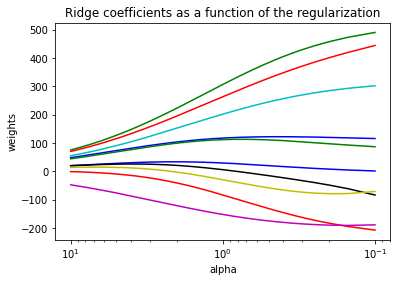

In [25]:
n_alphas = 200
ridge_alphas = np.logspace(-2, 6, n_alphas)
model = Ridge()

coefs = []
for a in alphas:
    model.set_params(alpha=a)
    model.fit(X, y)
    coefs.append(model.coef_)

ax = plt.gca()
ax.set_prop_cycle(cycler("color", ["b", "r", "g", "c", "k", "y", "m"]))

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.show()